In [24]:
# para poder importar src.config desde notebooks/
import sys
from pathlib import Path
root = Path.cwd()
if root.name == "notebooks":
    root = root.parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

# libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import INTERIM_DIR
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # <-- ESTE FALTABA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

Usando columnas -> fecha: InvoiceDate | cantidad: Quantity
InvoiceDate
2016-01-03    196062.0
2016-01-10    438547.0
2016-01-17    480731.0
2016-01-24    495151.0
2016-01-31    584468.0
Freq: W-SUN, Name: Quantity, dtype: float64


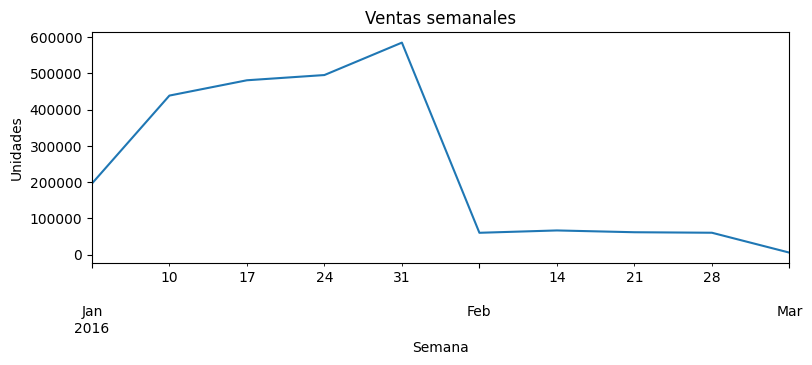

In [25]:
# 1) Carga ventas desde parquet (o csv si no existiera)
p_parq = INTERIM_DIR / "sales.parquet"
p_csv  = INTERIM_DIR / "sales.csv"
sales = pd.read_parquet(p_parq) if p_parq.exists() else pd.read_csv(p_csv, encoding="utf-8", low_memory=False)

# 2) Detecta columnas de fecha y cantidad según existan
date_col_candidates = ["SalesDate", "InvoiceDate", "Date"]
qty_col_candidates  = ["SalesQuantity", "Quantity", "Qty"]

date_col = next(c for c in date_col_candidates if c in sales.columns)
qty_col  = next(c for c in qty_col_candidates  if c in sales.columns)

# 3) Tipos correctos y serie semanal
sales[date_col] = pd.to_datetime(sales[date_col], errors="coerce")
ts = (
    sales
    .set_index(date_col)
    .resample("W")[qty_col]
    .sum()
    .astype(float)
    .fillna(0.0)
)

print(f"Usando columnas -> fecha: {date_col} | cantidad: {qty_col}")
print(ts.head())

# 4) Vista rápida
ax = ts.plot(title="Ventas semanales", figsize=(9,3))
ax.set_xlabel("Semana"); ax.set_ylabel("Unidades")
plt.show()

In [ ]:
import sys, pkgutil
print("Python:", sys.executable)
print("Version:", sys.version)
print("Tiene matplotlib?:", any(m.name=="matplotlib" for m in pkgutil.iter_modules()))

Python: /Users/chrxsmac/Documents/Final Project/inventario_predictivo/.venv/bin/python
Version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 11:23:37) [Clang 14.0.6 ]
Tiene matplotlib?: True


Baseline RMSE=39729.00  MAPE=476.7%
Holt (sin/ con estacionalidad) RMSE=24404.87  MAPE=115.5%


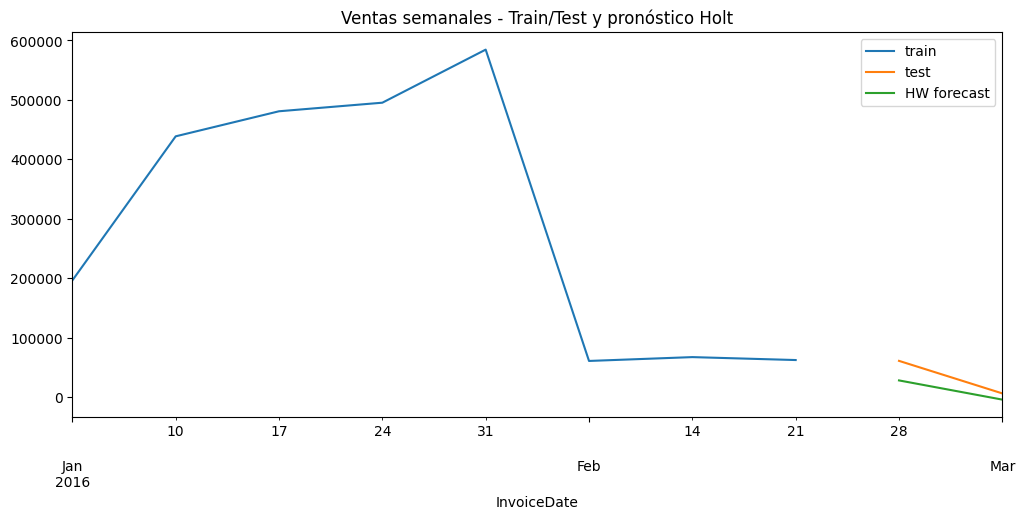

In [27]:
# --- SPLIT TRAIN/TEST ---
h = min(8, max(1, len(ts)//4))   # pronóstico a 8 semanas si se puede
train = ts.iloc[:-h] if len(ts) > h else ts.iloc[:0]
test  = ts.iloc[-h:] if len(ts) > h else ts.iloc[0:0]

# --- BASELINE INGENUO ---
if len(train) > 0:
    yhat_naive = np.repeat(train.iloc[-1], len(test)) if len(test) > 0 else np.array([])
else:
    yhat_naive = np.array([])

# --- HOLT (sin estacionalidad si no hay datos suficientes) ---
use_seasonal = False
seasonal_periods = 12  # solo se activará si hay datos suficientes (>= 2*sp)
if len(train) >= 2 * seasonal_periods:
    use_seasonal = True

if len(train) >= 3:
    if use_seasonal:
        model = ExponentialSmoothing(
            train,
            trend="add",
            seasonal="add",
            seasonal_periods=seasonal_periods,
            initialization_method="estimated",
        )
    else:
        model = ExponentialSmoothing(
            train,
            trend="add",
            seasonal=None,
            initialization_method="estimated",
        )
    fit = model.fit(optimized=True)
    fcast_test = fit.forecast(len(test)) if len(test) > 0 else pd.Series(dtype=float)
else:
    # serie demasiado corta para Holt -> solo baseline
    fcast_test = pd.Series(yhat_naive, index=test.index) if len(test) > 0 else pd.Series(dtype=float)

# --- MÉTRICAS ---
if len(test) > 0:
    mse_naive = mean_squared_error(test, yhat_naive) if len(yhat_naive) else np.nan
    mape_naive = mape(test, yhat_naive) if len(yhat_naive) else np.nan
    mse_hw = mean_squared_error(test, fcast_test) if len(fcast_test) else np.nan
    mape_hw = mape(test, fcast_test) if len(fcast_test) else np.nan
else:
    mse_naive = mape_naive = mse_hw = mape_hw = np.nan

print(f"Baseline RMSE={np.sqrt(mse_naive):.2f}  MAPE={mape_naive:.1f}%")
print(f"Holt (sin/ con estacionalidad) RMSE={np.sqrt(mse_hw):.2f}  MAPE={mape_hw:.1f}%")

# --- GRÁFICO ---
plt.figure(figsize=(12, 5))
train.plot(label="train")
if len(test) > 0: test.plot(label="test")
if len(fcast_test) > 0: fcast_test.plot(label="HW forecast")
plt.title("Ventas semanales - Train/Test y pronóstico Holt")
plt.legend(); plt.show()

# --- OPCIONAL: GUARDAR PRONÓSTICO ---
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
out = pd.DataFrame({"date": fcast_test.index, "yhat": fcast_test.values})
out.to_csv(PROCESSED_DIR/"forecast_weekly.csv", index=False)

In [ ]:
# horizonte futuro (semanas)
h_future = 12
f_future = fit.forecast(h_future).rename("forecast_qty").reset_index()
f_future.columns = ["Week", "forecast_qty"]
f_future.head()

,Week,forecast_qty
0,2016-02-28,27782.689045
1,2016-03-06,-4536.640982
2,2016-03-13,-36855.971008
3,2016-03-20,-69175.301035
4,2016-03-27,-101494.631061


In [30]:
# demanda diaria para políticas (aprox)
if 'date_col' not in locals() or 'qty_col' not in locals():
    date_candidates = [c for c in sales.columns if c.lower() in ('salesdate','invoicedate','date')]
    qty_candidates  = [c for c in sales.columns if c.lower() in ('salesquantity','quantity','salesqty')]
    date_col = date_candidates[0]
    qty_col  = qty_candidates[0]
    sales[date_col] = pd.to_datetime(sales[date_col], errors='coerce')
    sales[qty_col]  = pd.to_numeric(sales[qty_col], errors='coerce').fillna(0)

# Demanda diaria
ts_d = (
    sales.set_index(date_col)
         .resample('D')[qty_col]
         .sum()
         .fillna(0.0)
         .astype(float)
)

mu_d    = ts_d.mean()
sigma_d = ts_d.std(ddof=1)

# Parámetros (ajústalos con tu equipo)
lead_days = 7
z         = 1.65   # ~95% servicio
D_year    = ts_d.sum()
S         = 50.0   # costo pedido
H         = 2.0    # costo anual por unidad

SS  = z * sigma_d * np.sqrt(lead_days)      # Safety Stock
ROP = mu_d * lead_days + SS                 # Reorder Point
EOQ = np.sqrt(2 * max(D_year,1e-6) * S / max(H,1e-6))

policy = pd.DataFrame([{
    "mu_daily": mu_d, "sigma_daily": sigma_d, "lead_days": lead_days,
    "service_z": z, "safety_stock": SS, "reorder_point": ROP, "EOQ": EOQ
}])

policy

,mu_daily,sigma_daily,lead_days,service_z,safety_stock,reorder_point,EOQ
0,40852.816667,38472.384148,7,1.65,167950.79532,453920.511987,11070.611998


In [33]:
## Outputs para Power BI
from src.config import PROCESSED_DIR
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

out_forecast = PROCESSED_DIR / "sales_forecast_weekly.csv"
out_policy   = PROCESSED_DIR / "inventory_policy.csv"

f_future.to_csv(out_forecast, index=False)
policy.to_csv(out_policy, index=False)

print("Guardados:\n", out_forecast, "\n", out_policy)

Guardados:
 /Users/chrxsmac/Documents/Final Project/inventario_predictivo/data/processed/sales_forecast_weekly.csv 
 /Users/chrxsmac/Documents/Final Project/inventario_predictivo/data/processed/inventory_policy.csv


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from src.config import INTERIM_DIR, PROCESSED_DIR

## Análisis Predictivo

InvoiceDate
2016-01-03    196062.0
2016-01-10    438547.0
2016-01-17    480731.0
2016-01-24    495151.0
2016-01-31    584468.0
Freq: W-SUN, Name: Quantity, dtype: float64

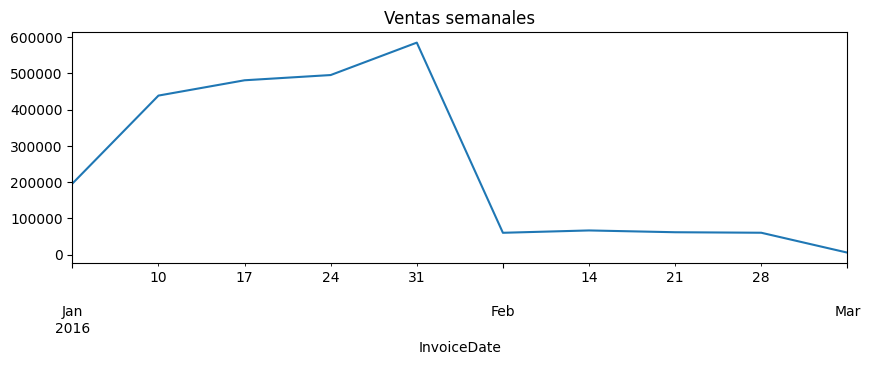

In [35]:
# Cargar ventas desde interim (parquet o csv)
p_parq, p_csv = INTERIM_DIR/"sales.parquet", INTERIM_DIR/"sales.csv"
sales = pd.read_parquet(p_parq) if p_parq.exists() else pd.read_csv(p_csv, encoding="utf-8", low_memory=False)

# Autodetectar columnas clave
date_candidates = [c for c in sales.columns if c.lower() in ("salesdate","invoicedate","date")]
qty_candidates  = [c for c in sales.columns if c.lower() in ("salesquantity","quantity","salesqty")]
date_col, qty_col = date_candidates[0], qty_candidates[0]

# Tipos correctos
sales[date_col] = pd.to_datetime(sales[date_col], errors="coerce")
sales[qty_col]  = pd.to_numeric(sales[qty_col], errors="coerce").fillna(0)

# Serie semanal
ts_w = (sales.set_index(date_col)
              .resample("W") [qty_col]
              .sum()
              .astype(float)
              .fillna(0.0))

display(ts_w.head())
ts_w.plot(title="Ventas semanales", figsize=(10,3)); plt.show()

Baseline  RMSE=39729.00, MAPE=4.767
HoltWinters RMSE=24404.87, MAPE=1.155


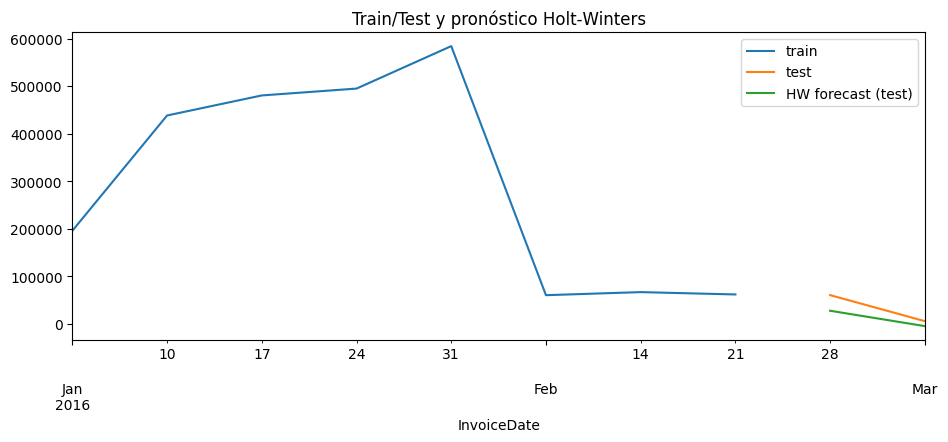

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Split (últimas 8 semanas como test si alcanza)
h = min(8, max(1, len(ts_w)//4))
train = ts_w.iloc[:-h] if len(ts_w) > h else ts_w
test  = ts_w.iloc[-h:]  if len(ts_w) > h else ts_w.iloc[0:0]

# Baseline: último valor
yhat_naive = np.repeat(train.iloc[-1], len(test)) if len(test) else np.array([])

# Holt-Winters (sin estacionalidad si la serie es corta)
use_seasonal = len(train) >= 24   # activa estacionalidad solo si hay datos suficientes
model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal=("add" if use_seasonal else None),
    seasonal_periods=(12 if use_seasonal else None),
    initialization_method="estimated"
)
fit = model.fit(optimized=True)
fcst_test = fit.forecast(len(test)) if len(test) else pd.Series(dtype=float)

# Métricas
if len(test) > 0:
    # Naive
    mse_naive = mean_squared_error(test, yhat_naive)   # sin 'squared'
    rmse_naive = np.sqrt(mse_naive)

    # Holt‑Winters
    mse_hw = mean_squared_error(test, fcast_test)      # sin 'squared'
    rmse_hw = np.sqrt(mse_hw)

    # MAPE (esto sí igual)
    mape_naive = mean_absolute_percentage_error(test, yhat_naive)
    mape_hw    = mean_absolute_percentage_error(test, fcast_test)
else:
    rmse_naive = mape_naive = np.nan
    rmse_hw    = mape_hw    = np.nan

print(f"Baseline  RMSE={rmse_naive:.2f}, MAPE={mape_naive:.3f}")
print(f"HoltWinters RMSE={rmse_hw:.2f}, MAPE={mape_hw:.3f}")

# Gráfico
plt.figure(figsize=(11,4))
train.plot(label="train")
if len(test): test.plot(label="test")
if len(test): fcst_test.plot(label="HW forecast (test)")
plt.legend(); plt.title("Train/Test y pronóstico Holt‑Winters"); plt.show()




In [47]:
## Pronóstico a futuro y guardado para el dashboard
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

h_future = 12  # semanas hacia adelante
fcst_future = fit.forecast(h_future).rename("forecast_qty")
out = fcst_future.reset_index().rename(columns={"index":"Week"})
out_path = PROCESSED_DIR/"sales_forecast_weekly.csv"
out.to_csv(out_path, index=False)
print("✅ Guardado:", out_path)
display(out.head())

✅ Guardado: /Users/chrxsmac/Documents/Final Project/inventario_predictivo/data/processed/sales_forecast_weekly.csv


,Week,forecast_qty
0,2016-02-28,27782.689045
1,2016-03-06,-4536.640982
2,2016-03-13,-36855.971008
3,2016-03-20,-69175.301035
4,2016-03-27,-101494.631061


In [48]:
## Políticas de inventario con demanda diaria (ROP, SS, EQQ)
# Serie diaria para políticas
ts_d = (sales.set_index(date_col)[qty_col]
              .resample("D").sum().astype(float).fillna(0.0))

mu_d    = ts_d.mean()
sigma_d = ts_d.std(ddof=1)
lead_days = 7
z         = 1.65     # ~95% servicio
D_year    = max(ts_d.sum(), 1e-6)
S, H      = 50.0, 2.0

SS  = z * sigma_d * np.sqrt(lead_days)
ROP = mu_d * lead_days + SS
EOQ = np.sqrt(2 * D_year * S / max(H,1e-6))

policy = pd.DataFrame([{
    "mu_daily": mu_d, "sigma_daily": sigma_d, "lead_days": lead_days,
    "service_z": z, "safety_stock": SS, "reorder_point": ROP, "EOQ": EOQ
}])
policy_path = PROCESSED_DIR/"inventory_policy_overall.csv"
policy.to_csv(policy_path, index=False)
print("✅ Guardado:", policy_path)
display(policy)

✅ Guardado: /Users/chrxsmac/Documents/Final Project/inventario_predictivo/data/processed/inventory_policy_overall.csv


,mu_daily,sigma_daily,lead_days,service_z,safety_stock,reorder_point,EOQ
0,40852.816667,38472.384148,7,1.65,167950.79532,453920.511987,11070.611998
